# Image metadata

2025-10-28 13:03:26.819 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-10-28 13:03:26.912 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'


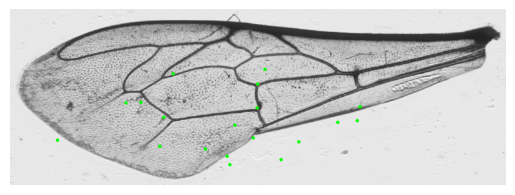

In [1]:
import cv2
import numpy as np
import torch
from PIL import Image

from wings.visualizing.visualize import visualize_coords

# open the image
path = "img.png"
image = Image.open(path)
image.load()

s = image.info['IdentiFly']

part = s.split("landmarks:")[1].split(";")[0]

# zamień na listę liczb
numbers = [int(x) for x in part.split()]
# ułóż w tablicę (n, 2)
landmarks = np.array(numbers).reshape(-1, 2)

# print(landmarks)

img = cv2.imread(path, cv2.IMREAD_COLOR)
img = visualize_coords(img, torch.tensor(numbers), spot_size=3)


In [2]:
from wings.modeling.loss import DiceLoss
from wings.modeling.litnet import LitNet
from wings.config import PROCESSED_DATA_DIR, MODELS_DIR
import torch

mean_coords = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "mean_shape.pth", weights_only=False
)

checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()


Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


LitNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNor

In [79]:
from tqdm import tqdm
import os
from wings.config import RAW_DATA_DIR
from wings.gpa import recover_order, procrustes_align, normalize_shape, center_shape
from wings.visualizing.image_preprocess import unet_fit_rectangle_preprocess, final_coords
from wings.utils import load_image
from PIL import Image
import numpy as np
import torch

original_labels = []
predicted_labels = []
predicted20_labels = []
bad_masks = 0
bad_indices = []
group_indices = []
gpas = []

points20idx = []
points18idx = []
points17idx = []
points21idx = []

directory = RAW_DATA_DIR / "pulawy" / "01_00_01"

all_files = []
for subdir, _, files in os.walk(directory):
    for file in files:
        if file.lower().endswith('.png'):
            img_path = os.path.join(subdir, file)
            all_files.append(img_path)

for idx, img_path in enumerate(tqdm(all_files, desc="Processing images")):
    image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)

    if x_size == 5782:
        group_indices.append(idx)
        continue

    img = Image.open(img_path)
    img.load()
    meta = img.info['IdentiFly']
    orig = meta.split("landmarks:")[1].split(";")[0]
    labels = [int(x) for x in orig.split()]
    coordinates = np.array(labels).reshape(-1, 2)
    coordinates[:, 1] = y_size - coordinates[:, 1] - 1
    original_labels.append(coordinates)

    output = model(image_tensor.cuda().unsqueeze(0))
    mask = torch.round(output).squeeze().detach().cpu().numpy()
    mask_coords = final_coords(mask, x_size, y_size)
    mask_coords = torch.tensor(mask_coords)

    if len(mask_coords) == 19:
        reordered = recover_order(mean_coords, mask_coords)
        gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
        gpas.append(gpa.cpu().numpy())
        predicted_labels.append(reordered.cpu().numpy())
        continue
    elif len(mask_coords) == 20:
        points20idx.append(idx)
        best_loss = float('inf')
        best_coords = None
        best_idx = -1

        for i in range(20):
            reduced = torch.cat([mask_coords[:i], mask_coords[i + 1:]], dim=0)
            reordered = recover_order(mean_coords, reduced)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
            loss = torch.norm(gpa - mean_coords).item()
            if loss < best_loss:
                best_loss = loss
                best_coords = reduced
                best_idx = i
        predicted20_labels.append(best_coords.cpu().numpy())
    elif len(mask_coords) == 18:
        points18idx.append(idx)
    elif len(mask_coords) > 20:
        points21idx.append(idx)
    elif len(mask_coords) < 18:
        points17idx.append(idx)

    bad_masks += 1
    bad_indices.append(idx)

print(f"Total samples: {len(original_labels) + bad_masks}")
print(f"Failed masks: {bad_masks}")

original_labels = np.stack(original_labels)
predicted_labels = np.stack(predicted_labels)
predicted20_labels = np.stack(predicted20_labels)
gpas = np.stack(gpas)

print(f"{original_labels.shape=}")
print(f"{predicted_labels.shape=}")
print(f"{predicted20_labels.shape=}")
print(f"{gpas.shape=}")


Processing images: 100%|██████████| 1092/1092 [00:35<00:00, 30.66it/s]

Total samples: 1095
Failed masks: 83
original_labels.shape=(1012, 19, 2)
predicted_labels.shape=(929, 19, 2)
predicted20_labels.shape=(71, 19, 2)
gpas.shape=(929, 19, 2)


In [80]:
print(f"{len(points17idx)=}")
print(f"{len(points18idx)=}")
print(f"{len(points20idx)=}")
print(f"{len(points21idx)=}")

len(points17idx)=1
len(points18idx)=2
len(points20idx)=71
len(points21idx)=9


In [236]:
errors = np.linalg.norm(predicted_labels - original_labels, axis=2)  # shape: (n_samples, 19)
gpa_errors = np.linalg.norm(mean_coords.cpu().numpy() - gpas, axis=2)
errors.size


ValueError: operands could not be broadcast together with shapes (929,19,2) (1012,19,2) 

In [ ]:
import pandas as pd

mean = errors.mean()
median = np.median(errors)

mean_error = errors.mean(axis=0)
min_error = errors.min(axis=0)
max_error = errors.max(axis=0)

rmse_error = np.sqrt(np.mean(errors ** 2, axis=0))
median_error = np.median(errors, axis=0)

df = pd.DataFrame(
    {
        "MAE": mean_error,
        "RMSE": rmse_error,
        "Median": median_error,
        "Min": min_error,
        "Max": max_error,
    }, index=np.arange(1, 20)
)

print(f"{mean=}")
print(f"{median=}\n")

df.index.name = "Point"
df = df.round(3)

print(df)


In [ ]:
mean_per_image = errors.mean(axis=1)
# mean_per_image = np.sqrt(np.mean(errors**2, axis=1))
gpa_error_per_image = gpa_errors.mean(axis=1)

mae = np.mean(np.abs(mean_per_image))
rmse = np.sqrt(np.mean(mean_per_image ** 2))
median_error = np.median(mean_per_image)
min_error = np.min(mean_per_image)
max_error = np.max(mean_per_image)

df = pd.DataFrame(
    {
        "MAE": [mae],
        "RMSE": [rmse],
        "Median": [median_error],
        "Min": [min_error],
        "Max": [max_error]
    }
).round(3)

print(df)


In [ ]:
import matplotlib.pyplot as plt

max_error_per_image = np.max(errors, axis=1)

plt.figure()
plt.scatter(mean_per_image, gpa_error_per_image)

plt.title("Mean vs GPA Error")
plt.xlabel("Mean error per Image")
plt.ylabel("GPA Error per Image")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()


In [235]:
import numpy as np

n = 10

flat_errors = errors.flatten()

# Get indices of top-n largest errors
top_n_flat_indices = np.argpartition(-flat_errors, n)[:n]
top_n_flat_indices = top_n_flat_indices[np.argsort(-flat_errors[top_n_flat_indices])]

# Convert back to 2D indices (sample index, inner index)
top_n_indices_2d = np.array(np.unravel_index(top_n_flat_indices, errors.shape)).T  # shape: (n, 2)
top_n_sample_indices = top_n_indices_2d[:, 0]

all_indices = list(range(len(all_files)))
good_indices = [i for i in all_indices if (i not in bad_indices) and (i not in group_indices)]

original_dataset_indices_per_point = [good_indices[i] for i in top_n_sample_indices]

print("Top-n errors (dataset_index, point, error_value):")
for idx, ((sample_idx, inner_idx), dataset_idx) in enumerate(zip(top_n_indices_2d, original_dataset_indices_per_point)):
    print(
        f"{idx + 1:2.0f}:\tIndex={dataset_idx:5.0f}\t\tPoint {inner_idx + 1:2.0f}\tError={errors[sample_idx, inner_idx]:7.2f}"
    )

print(original_dataset_indices_per_point)


NameError: name 'errors' is not defined

In [ ]:
import numpy as np

n = 10

mean_errors_per_image = np.mean(errors, axis=1)  # shape: (n_images,)

top_n_indices = np.argpartition(-mean_errors_per_image, n)[:n]
top_n_indices = top_n_indices[np.argsort(-mean_errors_per_image[top_n_indices])]

all_indices = list(range(len(all_files)))
good_indices = [i for i in all_indices if (i not in bad_indices) and (i not in group_indices)]
original_dataset_indices_per_image = [good_indices[i] for i in top_n_indices]

print("Top-n images with largest mean error (dataset_index, mean_error):")
for rank, (sample_idx, dataset_idx) in enumerate(zip(top_n_indices, original_dataset_indices_per_image), start=1):
    print(f"{rank:2}: Index={dataset_idx:5}\t\tMean error={mean_errors_per_image[sample_idx]:7.3f}")


In [ ]:
threshold = 3.5

num_errors_above_threshold = np.sum(errors > threshold)
total_points = errors.size
percentage = (num_errors_above_threshold / total_points) * 100

print(f"Number of points with error > {threshold}: {num_errors_above_threshold}")
print(f"Percent of all points: {percentage:.2f}%")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

flat_errors = errors.flatten()
# m = int(np.ceil(flat_errors.max()))
m = 8

x_values = np.arange(0, m + 1)

counts = [np.sum(flat_errors > x) for x in x_values]
percentages = [100 * c / len(flat_errors) for c in counts]

# Graph
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Number of points (error > x)')
ax1.set_xlabel('Error threshold')
ax1.set_ylabel('Number of points')
# ax1.set_yscale('log')  # logaritmic scale
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Number and percentage of points with error greater than x')

ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Percentage of points (%)')
ax2.set_ylabel('Percentage of all points')

# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_errors_per_image = np.mean(errors, axis=1)

m = 8
x_values = np.arange(1, m + 1)

counts = [np.sum(mean_errors_per_image > x) for x in x_values]
percentages = [100 * c / len(mean_errors_per_image) for c in counts]

fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Number of images (mean error > x)')
ax1.set_xlabel('Error threshold')
ax1.set_ylabel('Number of images')
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Number and percentage of images with mean error greater than x')

ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Percentage of images (%)')
ax2.set_ylabel('Percentage of all images')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
threshold = 3

mean_errors_per_image = np.mean(errors, axis=1)

num_images_above_threshold = np.sum(mean_errors_per_image > threshold)
total_images = len(mean_errors_per_image)
percentage = (num_images_above_threshold / total_images) * 100

print(f"Number of images with mean error > {threshold}: {num_images_above_threshold}")
print(f"Percent of all images: {percentage:.2f}%")


In [237]:
all_indices = list(range(len(all_files)))
good_indices = [i for i in all_indices if (i not in bad_indices) and (i not in group_indices)]

values = good_indices
values_iter = iter(values)
max_n = len(values)
max_n



929

113
888 320
22


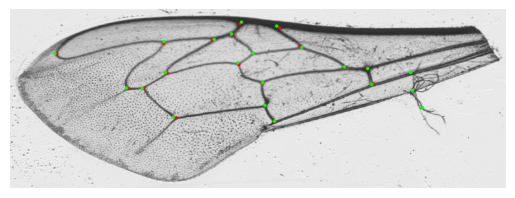

In [101]:
from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2

try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)

img_path = all_files[n]
image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
print(n)
print(x_size, y_size)

img = Image.open(img_path)
img.load()
meta = img.info['IdentiFly']
orig = meta.split("landmarks:")[1].split(";")[0]
labels = [int(x) for x in orig.split()]
coordinates = np.array(labels).reshape(-1, 2)
coordinates[:, 1] = y_size - coordinates[:, 1] - 1

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
spot_size = 3
filename = Path(img_path).name
img = visualize_coords(img, coordinates.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)

output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()
mask_coords = final_coords(mask, x_size, y_size)
mask_coords = torch.tensor(mask_coords)
print(len(mask_coords))
img = visualize_coords(img, mask_coords.flatten(), spot_size=spot_size, color=(0, 255, 0), show=True)
if len(mask_coords) == 19:
    reordered = recover_order(mean_coords, mask_coords)
elif len(mask_coords) == 20:
    best_loss = float('inf')
    best_coords = None
    best_idx = -1

    for i in range(20):
        reduced = torch.cat([mask_coords[:i], mask_coords[i + 1:]], dim=0)
        reordered = recover_order(mean_coords, reduced)
        gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
        loss = torch.norm(gpa - mean_coords).item()
        if loss < best_loss:
            best_loss = loss
            best_coords = reduced
            best_idx = i
    mask_coords = best_coords

reordered = recover_order(mean_coords, mask_coords)
img2 = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 0, 255), filename=f"{n}: {filename}")


827 320
18


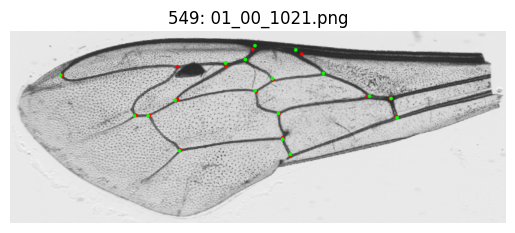

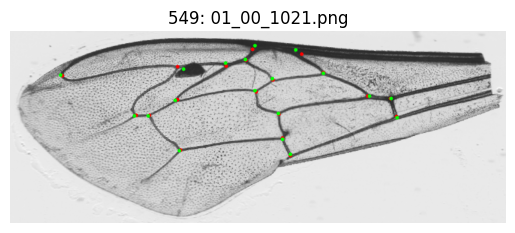

In [184]:
from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
import itertools

try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)

img_path = all_files[n]
image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
print(x_size, y_size)

img = Image.open(img_path)
img.load()
meta = img.info['IdentiFly']
orig = meta.split("landmarks:")[1].split(";")[0]
labels = [int(x) for x in orig.split()]
coordinates = np.array(labels).reshape(-1, 2)
coordinates[:, 1] = y_size - coordinates[:, 1] - 1

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
spot_size = 3
filename = Path(img_path).name
img = visualize_coords(img, coordinates.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)

output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()
mask_coords = final_coords(mask, x_size, y_size)
mask_coords = torch.tensor(mask_coords)
print(len(mask_coords))
img = visualize_coords(img, mask_coords.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")
if len(mask_coords) == 19:
    reordered = recover_order(mean_coords, mask_coords)
elif len(mask_coords) > 19:
    extra_points = len(mask_coords) - len(mean_coords)
    best_loss = float('inf')
    best_coords = None

    if extra_points <= 3:
        for remove_idx in itertools.combinations(range(len(mask_coords)), extra_points):
            reduced = torch.stack(
                [p for i, p in enumerate(mask_coords) if i not in remove_idx]
            )
            reordered = recover_order(mean_coords, reduced)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
            loss = torch.norm(gpa - mean_coords).item()
            if loss < best_loss:
                best_loss = loss
                best_coords = reduced
        mask_coords = best_coords
    else:
        mask_coords = mask_coords[:19]

elif len(mask_coords) == 18:
    best_loss = float('inf')
    best_missing_idx = None
    best_reordered = None
    best_temp_mean = None
    for remove_idx in range(len(mean_coords)):
        temp_mean = torch.stack(
            [p for i, p in enumerate(mean_coords) if i != remove_idx]
        )
        reordered = recover_order(temp_mean, mask_coords)
        gpa = procrustes_align(normalize_shape(center_shape(reordered)), temp_mean)
        loss = torch.norm(gpa - temp_mean).item()

        if loss < best_loss:
            best_loss = loss
            best_missing_idx = remove_idx
            best_reordered = reordered
            best_temp_mean = temp_mean

    t = best_reordered.mean(dim=0, keepdim=True)
    s = torch.norm(center_shape(best_reordered)).item()
    r = procrustes_align(normalize_shape(center_shape(best_reordered)), best_temp_mean, only_matrix=True)

    mean_coords_temp = (mean_coords @ r.T) * s + t
    missing_point = mean_coords_temp[best_missing_idx].unsqueeze(0)

    mask_coords = torch.cat(
        [
            best_reordered[:best_missing_idx],
            missing_point,
            best_reordered[best_missing_idx:]
        ], dim=0
    )

reordered = recover_order(mean_coords, mask_coords)
img2 = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")


900 325
18


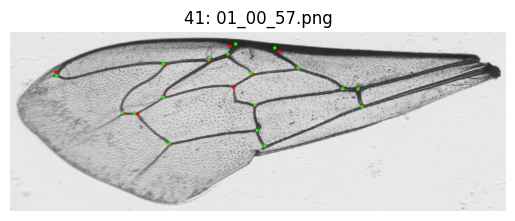

missing_points_tensor=tensor([[402.6960, 222.7157]])


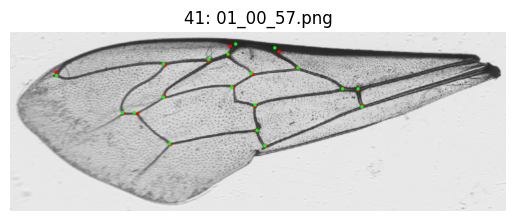

In [272]:
from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
import itertools

try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)

img_path = all_files[n]
image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
print(x_size, y_size)

img = Image.open(img_path)
img.load()
meta = img.info['IdentiFly']
orig = meta.split("landmarks:")[1].split(";")[0]
labels = [int(x) for x in orig.split()]
coordinates = np.array(labels).reshape(-1, 2)
coordinates[:, 1] = y_size - coordinates[:, 1] - 1

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
spot_size = 3
filename = Path(img_path).name
img = visualize_coords(img, coordinates.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)

output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()
mask_coords = final_coords(mask, x_size, y_size)
mask_coords = torch.tensor(mask_coords)
idx = torch.randperm(mask_coords.size(0))
mask_coords = mask_coords[idx][:18]
print(len(mask_coords))
img = visualize_coords(img, mask_coords.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")
if len(mask_coords) == 19:
    reordered = recover_order(mean_coords, mask_coords)
elif len(mask_coords) > 19:
    extra_points = len(mask_coords) - len(mean_coords)
    best_loss = float('inf')
    best_coords = None

    if extra_points <= 3:
        for remove_idx in itertools.combinations(range(len(mask_coords)), extra_points):
            reduced = torch.stack(
                [p for i, p in enumerate(mask_coords) if i not in remove_idx]
            )
            reordered = recover_order(mean_coords, reduced)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
            loss = torch.norm(gpa - mean_coords).item()
            if loss < best_loss:
                best_loss = loss
                best_coords = reduced
        mask_coords = best_coords
    else:
        mask_coords = mask_coords[:19]

elif len(mask_coords) <= 18:
    missing_points = len(mean_coords) - len(mask_coords)
    best_loss = float('inf')
    best_missing_idxs = None
    best_reordered = None
    best_temp_mean = None

    if missing_points <= 3:
        for remove_idx in itertools.combinations(range(len(mean_coords)), missing_points):
            temp_mean = torch.stack(
                [p for i, p in enumerate(mean_coords) if i not in remove_idx]
            )
            reordered = recover_order(temp_mean, mask_coords)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), temp_mean)
            loss = torch.norm(gpa - temp_mean).item()

            if loss < best_loss:
                best_loss = loss
                best_missing_idxs = remove_idx
                best_reordered = reordered
                best_temp_mean = temp_mean

        t = best_reordered.mean(dim=0, keepdim=True)
        s = torch.norm(center_shape(best_reordered))
        r = procrustes_align(normalize_shape(center_shape(best_reordered)), best_temp_mean, only_matrix=True)

        mean_coords_temp = (mean_coords @ r.T) * s + t
        missing_points_tensor = mean_coords_temp[list(best_missing_idxs)]
        print(f"{missing_points_tensor=}")

        mask_coords = torch.cat([best_reordered, missing_points_tensor], dim=0)
    else:
        xmin, ymin = mask_coords.min(dim=0).values
        xmax, ymax = mask_coords.max(dim=0).values
        random_x = torch.empty(missing_points).uniform_(xmin.item(), xmax.item())
        random_y = torch.empty(missing_points).uniform_(ymin.item(), ymax.item())
        random_points = torch.stack([random_x, random_y], dim=1)
        mask_coords = torch.cat([mask_coords, random_points], dim=0)

reordered = recover_order(mean_coords, mask_coords)
img2 = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")


834 318
15


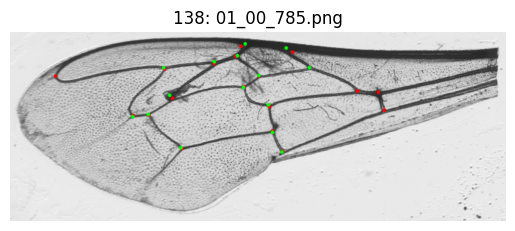

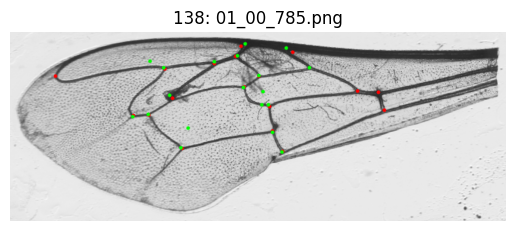

In [352]:
"""
jak usuwamy punkty z mean cords to one juz nie sa wycentrowane i znormalizowane
teraz jest zajebiscie
"""

from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
import itertools

try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)

img_path = all_files[n]
image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
print(x_size, y_size)

img = Image.open(img_path)
img.load()
meta = img.info['IdentiFly']
orig = meta.split("landmarks:")[1].split(";")[0]
labels = [int(x) for x in orig.split()]
coordinates = np.array(labels).reshape(-1, 2)
coordinates[:, 1] = y_size - coordinates[:, 1] - 1

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
spot_size = 3
filename = Path(img_path).name
img = visualize_coords(img, coordinates.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)

output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()
mask_coords = final_coords(mask, x_size, y_size)
mask_coords = torch.tensor(mask_coords)
idx = torch.randperm(mask_coords.size(0))
mask_coords = mask_coords[idx][:18]
print(len(mask_coords))
img = visualize_coords(img, mask_coords.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")
if len(mask_coords) == 19:
    reordered = recover_order(mean_coords, mask_coords)
elif len(mask_coords) > 19:
    extra_points = len(mask_coords) - len(mean_coords)
    best_loss = float('inf')
    best_coords = None

    if extra_points <= 3:
        for remove_idx in itertools.combinations(range(len(mask_coords)), extra_points):
            reduced = torch.stack(
                [p for i, p in enumerate(mask_coords) if i not in remove_idx]
            )
            reordered = recover_order(mean_coords, reduced)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
            loss = torch.norm(gpa - mean_coords).item()
            if loss < best_loss:
                best_loss = loss
                best_coords = reduced
        mask_coords = best_coords
    else:
        mask_coords = mask_coords[:19]

elif len(mask_coords) <= 18:
    missing_points = len(mean_coords) - len(mask_coords)
    best_loss = float('inf')
    best_missing_idxs = None
    best_reordered = None
    best_temp_mean = None

    if missing_points <= 3:
        for remove_idx in itertools.combinations(range(len(mean_coords)), missing_points):
            temp_mean = torch.stack(
                [p for i, p in enumerate(mean_coords) if i not in remove_idx]
            )
            temp_mean_cn = normalize_shape(center_shape(temp_mean))
            reordered = recover_order(temp_mean_cn, mask_coords)
            gpa = procrustes_align(normalize_shape(center_shape(reordered)), temp_mean_cn)
            loss = torch.norm(gpa - temp_mean_cn).item()

            if loss < best_loss:
                best_loss = loss
                best_missing_idxs = remove_idx
                best_reordered = reordered
                best_temp_mean = temp_mean

        t_coords = best_reordered.mean(dim=0, keepdim=True)
        s_coords = torch.norm(center_shape(best_reordered))

        t_mean = best_temp_mean.mean(dim=0, keepdim=True)
        s_mean = torch.norm(center_shape(best_temp_mean))

        r = procrustes_align(
            normalize_shape(center_shape(best_reordered)),
            normalize_shape(center_shape(best_temp_mean)),
            only_matrix=True
        )

        mean_coords_temp = ((mean_coords - t_mean) / s_mean) @ r.T * s_coords + t_coords
        missing_points_tensor = mean_coords_temp[list(best_missing_idxs)]
        print(f"{missing_points_tensor=}")

        mask_coords = torch.cat([best_reordered, missing_points_tensor], dim=0)
    else:
        xmin, ymin = mask_coords.min(dim=0).values
        xmax, ymax = mask_coords.max(dim=0).values
        random_x = torch.empty(missing_points).uniform_(xmin.item(), xmax.item())
        random_y = torch.empty(missing_points).uniform_(ymin.item(), ymax.item())
        random_points = torch.stack([random_x, random_y], dim=1)
        mask_coords = torch.cat([mask_coords, random_points], dim=0)

reordered = recover_order(mean_coords, mask_coords)
img2 = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")
